## Introduction

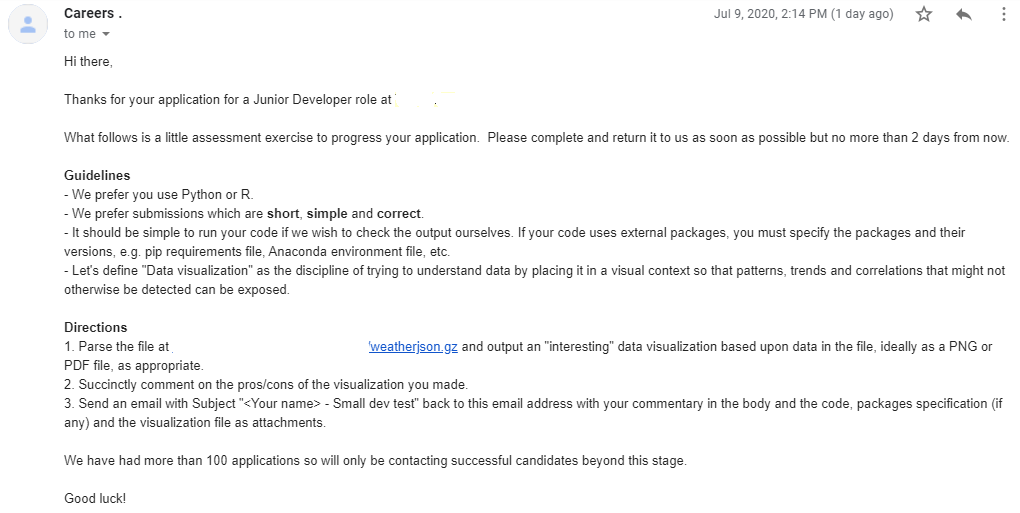

In [1]:
from IPython.display import Image

Image('assignment.png')

In [3]:
# imports
import gzip
import pathlib
import json
import matplotlib.pyplot as plt

from pprint import pprint
import pandas as pd

pd.set_option('display.max_rows', 101)

### Parsing the Data

In [4]:
path = pathlib.PureWindowsPath(r"..\weather.json.gz")
# path = pathlib.PurePath(r"..\weather.json.gz") # Unix

In [5]:
# open gzip file
# parse json bytes elements into Python dicts
with gzip.open(path) as f:
    lines = []
    for line in f.readlines():
        lines.append(
            json.loads(line)
        )

In [9]:
# consider the structure and underlying format of a data point
pprint(lines[0])

{'city': {'coord': {'lat': 34.790878, 'lon': 48.570728},
          'country': 'IR',
          'findname': 'AZADSHAHR',
          'id': 14256,
          'name': 'Azadshahr',
          'zoom': 10},
 'clouds': {'all': 90},
 'main': {'humidity': 71,
          'pressure': 1022,
          'temp': 287.07,
          'temp_max': 289.15,
          'temp_min': 284.15},
 'time': 1554462304,
 'weather': [{'description': 'overcast clouds',
              'icon': '04d',
              'id': 804,
              'main': 'Clouds'}],
 'wind': {'deg': 340, 'speed': 4.1}}


### Formulating a Hypothesis

<blockquote>Cities that are <b>further away</b> from the equator, have <b>higher wind speeds</b>, <b>higher pressure</b> and <b>higher humidity</b> are <b>more susceptible</b> to tropical cyclones</blockquote>

### Transforming the Data

In [6]:
def get_distance_from_equator(latitude: float) -> float:
    """
    Each degree of latitude represents 69 miles from the
    equator. Multiply that result by 1.60934 to get the distance
    in km.
    """
    return abs(latitude * 69 * 1.60934)

def extract_column_values(json_like: dict) -> tuple:
    """
    Performs a series of custom dictionary queries to extract
    minimal information to uniquely identify data points
    and carry out our visualisation.
    """
    _city_name = json_like["city"]["name"]
    _country_iso2 = json_like["city"]["country"]
    _pressure_mb = json_like["main"]["pressure"]
    _wind_speed_mph = json_like["wind"]["speed"]
    _humidity_pct = json_like["main"]["humidity"] / 100
    _distance_from_equator = get_distance_from_equator(
        json_like["city"]["coord"]["lat"]
    )
    
    return (
        _city_name,
        _country_iso2,
        _pressure_mb,
        _wind_speed_mph,
        _humidity_pct,
        _distance_from_equator
    )

In [7]:
# get values for pd.DataFrame object
city_name = []
country_iso2 = []
pressure_mb = []
wind_speed_mph = []
humidity_pct = []
distance_from_equator_km = []

for jsonlike in lines:
    cn, cios2, prs, ws, hmdty, d = extract_column_values(jsonlike)
    city_name.append(cn)
    country_iso2.append(cios2)
    pressure_mb.append(prs)
    wind_speed_mph.append(ws)
    humidity_pct.append(hmdty)
    distance_from_equator_km.append(d)

In [11]:
data = {
    "city_name": city_name,
    "country_iso2": country_iso2,
    "pressure_mb": pressure_mb,
    "wind_speed_mph": wind_speed_mph,
    "humidity_pct": humidity_pct,
    "distance_from_equator_km": distance_from_equator_km,
}

df = pd.DataFrame(data)

### Initial Glance at the Dataset

In [12]:
df.head(5)

,city_name,country_iso2,pressure_mb,wind_speed_mph,humidity_pct,distance_from_equator_km
0,Azadshahr,IR,1022.00,4.10,0.71,3863.334260
1,Jilib,SO,1008.39,5.72,0.36,54.221899
2,Kismaayo,SO,1009.87,6.12,1.00,39.772794
3,Eyl,SO,1010.67,5.02,0.80,886.168104
4,Kahriz,IR,1021.00,2.10,0.66,3818.130615


The values in the pressure column seem to be aggregated around 1000. This may pose a problem with distinguishing values when use the pressure feature as a visualisation layer (size of points). We therefore:
<ol><li>Remove values outside the desirable range</li><li>Note the percentage of data points lost</li><li>Create new truncated pd.DataFrame</li>.</ol>

In [17]:
cond1 = df["pressure_mb"] > 1000 
cond2 = df["pressure_mb"] < 1020

n_before_drop = len(df) 
n_discarded_below = len(
    df[df["pressure_mb"] < 1000]
)
n_discarded_above = len(
    df[df["pressure_mb"] > 1020]
)

pct = (n_before_drop - n_discarded_below - n_discarded_above) / n_before_drop 
print(f"Percentage of data points lost: {1 - pct:%}")

new_df = df.loc[cond1 & cond2]

Percentage of data points lost: 19.866971%


### Visualization Process

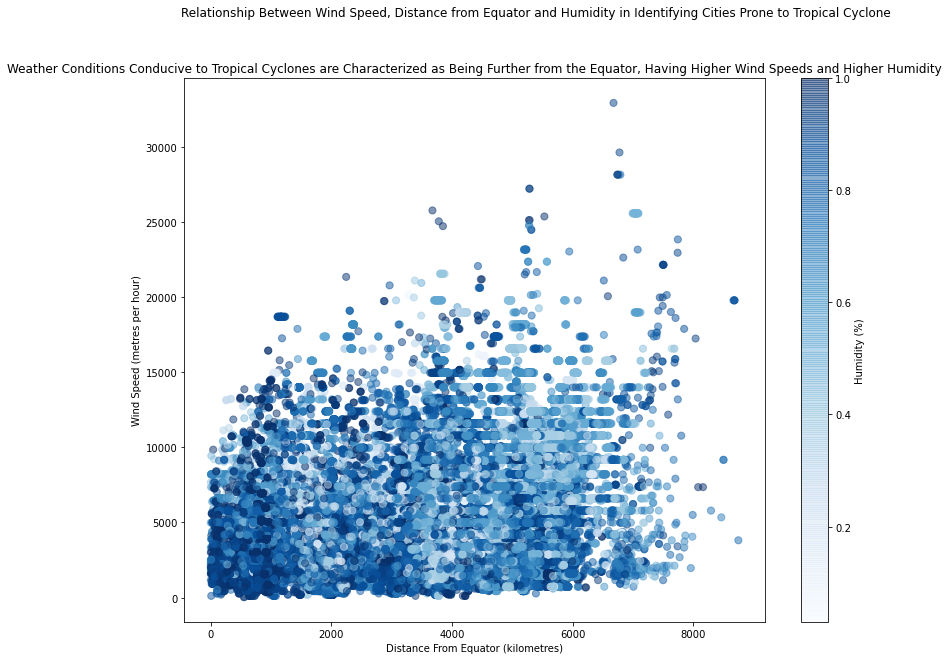

In [16]:
# figure
fig, ax1 = plt.subplots()
fig.set_size_inches(13, 10)
fig.suptitle("Relationship Between Wind Speed, Distance from Equator and Humidity in Identifying Cities Prone to Tropical Cyclone")

# labels
ax1.set_xlabel("Distance From Equator (kilometres)")
ax1.set_ylabel("Wind Speed (metres per hour)")
ax1.set_title("""Weather Conditions Conducive to Tropical Cyclones are Characterized as Being Further from the Equator, Having Higher Wind Speeds and Higher Humidity""")

# c sequence
c = new_df["humidity_pct"]

# plot
plt.scatter(
    new_df["distance_from_equator_km"],
    new_df["wind_speed_mph"] * 1609, # convert to meters per hour
    c = c,
    cmap = "Blues",
    s = new_df["pressure_mb"] * .05,
    alpha = .5
)
cbar = plt.colorbar()
# get plt.size equivalent to anotate size
cbar.set_label("Humidity (%)")

plt.savefig("final_visual.pdf")
plt.show()

### Pros

<ul>
    <li>Pressure, wind speed, humidty and distance from equation are bonified contributing factors to the occurrence of tropical cyclones.</li>
    <li>Using shades of blue to visualize humidity was a apt choice for two reasons:
    <ol>
    <li>The "blueness" of the data point is an easy-to-comprehend translation for what humidity actually is - the concentration of water vapor in the air.</li><li>The fact that humidity is measured as a percentage allows us to programmatically produce accurately-scaled colour intensity, further adding visual value.</li>
    </ol>
    </li>
    <li>Using x-axis for distance from equator was the best choice for distance.</li>
</ul>

### Cons

<ul>
    <li>Due to the nature of the data, other than distance from equator - which was transformed from the latitude value by the author - we were unable to
   work with cyclone-specific metrics such as:
        <ol>
            <li>Saturated lapse gradient.</li>
            <li>Vertical wind shear.</li>
        </ol>
    </li>
    <li>Since there were so many data points, using pressure as a feature made neglible contribution to the visual information despite being used in the size parameter, and so was not explicitly mentioned in the output visualisation.</li>
    <li>The author decided to use metres per hour as a measure for wind speed - which the author acknowledges is not a conventional metric but it provided for a similar scale as it's adjacent x-axis and allowed for more distinguishable data points.</li>
    <li>As is mentioned in the Jupyter Notebook, approximately 20% of the data points were lost in filter deviant pressure values since the variance was already so low.</li>
</ul>

### Further Remarks/Suggestions

<ul>
    <li>An additional layer of visualization would be a red lining around the datapoints that have experienced a tropical cyclone within a x kilometres in the past y years.</li>
    <li>If we had access to a sort of "recently_experienced_cyclone" binary variable outlined in (1), then we could build a predictive model using the variables employed in the visualisation, which the author imagines will account for the lion's share of variance explained.</li>
    <li>We could've used a generator in the file handling process instead of loading the entire file into memory at once with a list object. The latter approach worked in this case however the author notes that the former method is more favourable with increasing file size.</li>
    <li>The author could've encapsulated the series of append statements in a funciton, however Buraleh was averse to the prospect of a function mutation the state of objects in the global scope (side effects).</li>
</ul>

### References:

<ol>
    <li><a href="https://en.wikipedia.org/wiki/Tropical_cyclone">https://en.wikipedia.org/wiki/Tropical_cyclone</a></li>
    <li><a href="https://www.weather.gov/source/zhu/ZHU_Training_Page/tropical_stuff/hurricane_anatomy/hurricane_anatomy.html">https://www.weather.gov/source/zhu/ZHU_Training_Page/tropical_stuff/hurricane_anatomy/hurricane_anatomy.html</a></li>
        <li><a href=https://sciencing.com/distance-city-equator-7484864.html>https://sciencing.com/distance-city-equator-7484864.html</a></li>
    
</ol>